# <center>Private Property Prices and Foursquare Data Clustering Analysis<center>

<Center>Sng Jun Qiang<Center>

<Center>10 Jun 2019<Center>

### Table of contents

1. [Introduction: Business Problem](#BusinessProblem)
2. [Description of the Data](#Data)
    1. [Scrape Table from Web to get Postal District Code and Neighborhood](#ScrapeTable)
    2. [Data Processing](#DataProcessing)
    3. [Retrieve Top Venues of Each Neighborhoods](#TopVenues)
3. [Methodology: K-Means Clustering](#Analysis)
    1. [Cluster Neighborhoods](#Cluster)
    1. [Examine Results](#ExamineResults)
    1. [Discussion](#Discussion)
4. [Conclusion](#Conclusion)

### 1. Introduction: Business Problem<a name="BusinessProblem"></a>

Private property prices had been souring recently in Singapore. Demands often form correlationship with transportations, amenities, schools and etc. Other than the pevious mentioned obvious factors that caused the souring prices of private property, are factors such as resturants, cafes, bars, shopping malls or places of visit related to the prices of private property in Singapore?

This analysis will involve getting data from open source and Fourquare to analyse the relationships between private property prices in each neighborhoods district and their venues nearby (within 1km) which will provide information for buyers who are considering to purchase private property for personal residential needs or for investment purposes.

### 2.  Description of the Data<a name="Data"></a>

As the latitude and longitude of Singapore neighborhood are not available, the neighborhood list and postal district code will be retrieved from [wiki](https://en.wikipedia.org/wiki/Postal_codes_in_Singapore) and will be processed as shown below. Thereafter, the latitude and longitude will be retrieved using geopy and save as a dataframe 'sg_latlng'. Next, the prices per square feet of private property for 2017 and 2018 will be extracted from [Urban Redevelopment Authority (URA)](https://www.ura.gov.sg/Corporate/) as csv and merge with 'sg_latlng' to create dataframe 'sg_latlng_psf'. A function will be created to extract venues nearby from Foursquare to create dataframe 'sg_venues' and combine with 'sg_latlng_psf' to form final dataframe 'sg_venues_psf' for analysis.

In [1]:
import pandas as pd # Library for data analsysis
import numpy as np # Library to handle data in a vectorized manner
import json # Library to handle JSON files
import requests # Library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from geopy.geocoders import Nominatim

import folium # Map rendering library

from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

from bs4 import BeautifulSoup

# Import k-means from clustering stage
from sklearn.cluster import KMeans

### 2.A. Scrape Table from Web to get Postal District Code and Neighborhood<a name="ScrapeTable"></a>

Scrape table from web consisting of neighborhood in Singapore and create dataframe 'df1' consisting Postal District Code and Neighborhood. In addition, create dataframe 'df_postal_d' consisting only Postal District.

In [2]:
res1 = requests.get("https://en.wikipedia.org/wiki/Postal_codes_in_Singapore")
soup1 = BeautifulSoup(res1.content,'lxml')
table1 = soup1.find_all('table')[0] 
df1 = pd.read_html(str(table1))[0]
headers1 = df1.iloc[0]
df1  = pd.DataFrame(df1.values[1:], columns=headers1)
df1.rename(columns = {'Postal district': 'Postal District','General location': 'Neighborhood'}, inplace=True)
df1 = df1[['Postal District','Neighborhood']]
df_postal_d = pd.DataFrame(df1['Postal District'])
df1.head()

,Postal District,Neighborhood
0,01,"Raffles Place, Cecil, Marina, People's Park"
1,02,"Anson, Tanjong Pagar"
2,03,"Bukit Merah, Queenstown, Tiong Bahru"
3,04,"Telok Blangah, Harbourfront"
4,05,"Pasir Panjang, Hong Leong Garden, Clementi New..."


### 2.B. Data Processing<a name="DataProcessing"></a>

Split neighborhood into columns by ',' and combine  'df_postal_d' to 'df_neighborhood'.

In [3]:
df_neighborhood = pd.DataFrame(df1.Neighborhood.str.split(',').tolist())
df_combine = pd.concat([df_postal_d, df_neighborhood], axis=1, sort=False)
df_combine.head()

,Postal District,0,1,2,3
0,01,Raffles Place,Cecil,Marina,People's Park
1,02,Anson,Tanjong Pagar,None,None
2,03,Bukit Merah,Queenstown,Tiong Bahru,None
3,04,Telok Blangah,Harbourfront,None,None
4,05,Pasir Panjang,Hong Leong Garden,Clementi New Town,None


Stack all neighborhood columns into a single column with the correct Postal District.

In [4]:
df_combine = df_combine.set_index('Postal District').stack()
df_combine = df_combine.reset_index(name='Neighborhood')
df_combine = pd.DataFrame(df_combine.drop('level_1', axis=1))
df_combine.head()

,Postal District,Neighborhood
0,01,Raffles Place
1,01,Cecil
2,01,Marina
3,01,People's Park
4,02,Anson


Retrieve latitude and longitude of neighborhood in Singapore according to df1 and create dataframe df1_latlng.

In [5]:
geolocator = Nominatim()

df_combine_latlng = df_combine.copy()

latlng = df_combine_latlng.Neighborhood.apply(lambda neig: geolocator.geocode(neig))

df_combine_latlng["Latitude"] = [x.latitude for x in latlng]
df_combine_latlng["Longitude"] = [x.longitude for x in latlng]
df_combine_latlng

C:\Users\P1321155\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


,Postal District,Neighborhood,Latitude,Longitude
0,01,Raffles Place,1.283595,103.851568
1,01,Cecil,39.572943,-75.938181
2,01,Marina,36.690078,-121.800640
3,01,People's Park,37.865860,-122.257154
4,02,Anson,34.970585,-80.095819
5,02,Tanjong Pagar,1.276419,103.842929
6,03,Bukit Merah,4.559288,101.025582
7,03,Queenstown,-45.031720,168.660810
8,03,Tiong Bahru,1.286197,103.825765
9,04,Telok Blangah,1.270586,103.809863


Create dataframe 'sg_latlng' and save dataframe to csv for furture use. Further modification was made to csv due to incorrect latitude and longitude and created dataframe 'sg_latlng_edited'.

In [63]:
sg_latlng = pd.DataFrame(df_combine_latlng)
sg_latlng.to_csv("sg_latlng.csv", index=False)

In [64]:
sg_latlng_edited = pd.read_csv('sg_latlng(Edited).csv')
sg_latlng_edited['Postal District'] = sg_latlng_edited['Postal District'].astype(int)
sg_latlng_edited.head()

,Postal District,Neighborhood,Latitude,Longitude
0,1,Raffles Place,1.283595,103.851568
1,1,Cecil,1.280805,103.848668
2,1,Marina,1.263270,103.820293
3,1,People's Park,1.284139,103.842683
4,2,Anson,1.273845,103.844512


Extracting the private property prices per square feet for 2017 and 2018 from [Urban Redevelopment Authority (URA)](https://www.ura.gov.sg/Corporate/) as csv and merge with 'sg_latlng_edited'

In [65]:
psf = pd.read_csv('Prices.csv')
psf.head()

,Postal District,2017,2018
0,1,2333.80,2540.88
1,2,2366.87,3362.38
2,3,1746.67,1799.23
3,4,1951.18,0.00
4,5,1313.50,1514.37


In [66]:
sg_latlng_psf = pd.merge(sg_latlng_edited, psf, on='Postal District')
sg_latlng_psf.rename(columns = {'2017': '2017 psf','2018': '2018 psf'}, inplace=True)
print(sg_latlng_psf.shape)
sg_latlng_psf.head()

(75, 6)


,Postal District,Neighborhood,Latitude,Longitude,2017 psf,2018 psf
0,1,Raffles Place,1.283595,103.851568,2333.80,2540.88
1,1,Cecil,1.280805,103.848668,2333.80,2540.88
2,1,Marina,1.263270,103.820293,2333.80,2540.88
3,1,People's Park,1.284139,103.842683,2333.80,2540.88
4,2,Anson,1.273845,103.844512,2366.87,3362.38


Visualization of Neighborhoods in Singapore.

In [365]:
# Define Sg lat & lng
sg_lat = 1.3521
sg_lng = 103.8198

sg_map = folium.Map(location=[sg_lat, sg_lng], zoom_start=11)

# Add markers to map
for lat, lng, label in zip(sg_latlng_edited['Latitude'], sg_latlng_edited['Longitude'], sg_latlng_edited['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8,
        parse_html=False).add_to(sg_map)  

# Display map
sg_map

Define Foursquare Credentials and Version.

In [68]:
# @hidden_cell
CLIENT_ID = 'CDFQWILUEP4JGFAB1IY0EY35FNMJQBMRHCLIV42KV1ZYPOKC'
CLIENT_SECRET = '02X0FHBLBU31IYIWPPTXDJIE0OKXAHKOHDSEOXT3O3RDLLTJ'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CDFQWILUEP4JGFAB1IY0EY35FNMJQBMRHCLIV42KV1ZYPOKC
CLIENT_SECRET:02X0FHBLBU31IYIWPPTXDJIE0OKXAHKOHDSEOXT3O3RDLLTJ


In [69]:
LIMIT = 100 # Limit of number of venues returned by Foursquare API
radius = 500 # Define radius

Create function to explore the neighborhoods using Foursquare.

In [274]:
# Create a function to repeat the same process to all the neighborhoods in Singapore
def getNearbyVenuesSg(names, latitudes, longitudes, radius=1000):
    
    venues_list1=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # Create the API request URL
        url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results1 = requests.get(url1).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list1.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results1])

    nearby_venues1 = pd.DataFrame([item for venue_list in venues_list1 for item in venue_list])
    nearby_venues1.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues1)

In [275]:
# Using the function created in part 3 to run on each neighborhood and create a new dataframe called sg_venues
sg_venues = getNearbyVenuesSg(names=sg_latlng_psf['Neighborhood'],
                              latitudes=sg_latlng_psf['Latitude'],
                              longitudes=sg_latlng_psf['Longitude']
                             )

Raffles Place
 Cecil
 Marina
 People's Park
Anson
 Tanjong Pagar
Bukit Merah
 Queenstown
 Tiong Bahru
Telok Blangah
 Harbourfront
Pasir Panjang
 Hong Leong Garden
 Clementi New Town
High Street
 Beach Road (part)
Middle Road
 Golden Mile
Little India
 Farrer Park
 Jalan Besar
 Lavender
Orchard
 Cairnhill
 River Valley
Ardmore
 Bukit Timah
 Holland Road
 Tanglin
Watten Estate
 Novena
 Thomson
Balestier
 Toa Payoh
 Serangoon
Macpherson
 Braddell
Geylang
 Eunos
Katong
 Joo Chiat
 Amber Road
Bedok
 Upper East Coast
 Eastwood
 Kew Drive
Loyang
 Changi
Simei
 Tampines
 Pasir Ris
Serangoon Garden
 Hougang
 Punggol
Bishan
 Ang Mo Kio
Upper Bukit Timah
 Clementi Park
 Ulu Pandan
Jurong
 Tuas
Hillview
 Dairy Farm
 Bukit Panjang
 Choa Chu Kang
Lim Chu Kang
 Tengah
Kranji
 Woodgrove
 Woodlands
Upper Thomson
 Springleaf
Yishun
 Sembawang
Seletar


In [276]:
# Check size of sg_venues
print(sg_venues.shape)
sg_venues.head()

(4954, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Raffles Place,1.283595,103.851568,The Fullerton Bay Hotel,1.283878,103.853314,Hotel
1,Raffles Place,1.283595,103.851568,CITY Hot Pot Shabu shabu,1.284173,103.851585,Hotpot Restaurant
2,Raffles Place,1.283595,103.851568,Virgin Active,1.284608,103.850815,Gym / Fitness Center
3,Raffles Place,1.283595,103.851568,CULINARYON,1.284876,103.850933,Comfort Food Restaurant
4,Raffles Place,1.283595,103.851568,The Salad Shop,1.285523,103.851177,Salad Place


Merge 'sg_venues' to 'sg_latlng_psf' to get final data for analysis.

In [277]:
sg_venues_psf = pd.merge(sg_venues,sg_latlng_psf, on='Neighborhood')
sg_venues_psf = sg_venues_psf.drop(['Latitude', 'Longitude'], axis=1)
sg_venues_psf.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal District,2017 psf,2018 psf
0,Raffles Place,1.283595,103.851568,The Fullerton Bay Hotel,1.283878,103.853314,Hotel,1,2333.8,2540.88
1,Raffles Place,1.283595,103.851568,CITY Hot Pot Shabu shabu,1.284173,103.851585,Hotpot Restaurant,1,2333.8,2540.88
2,Raffles Place,1.283595,103.851568,Virgin Active,1.284608,103.850815,Gym / Fitness Center,1,2333.8,2540.88
3,Raffles Place,1.283595,103.851568,CULINARYON,1.284876,103.850933,Comfort Food Restaurant,1,2333.8,2540.88
4,Raffles Place,1.283595,103.851568,The Salad Shop,1.285523,103.851177,Salad Place,1,2333.8,2540.88


In [151]:
# Check how many venues were returned for each neighborhood
sg_venues_psf.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal District,2017 psf,2018 psf
Neighborhood,,,,,,,,,
Amber Road,32,32,32,32,32,32,32,32,32
Ang Mo Kio,47,47,47,47,47,47,47,47,47
Beach Road (part),95,95,95,95,95,95,95,95,95
Braddell,7,7,7,7,7,7,7,7,7
Bukit Panjang,10,10,10,10,10,10,10,10,10


In [278]:
# Find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(sg_venues_psf['Venue Category'].unique())))

There are 306 uniques categories.


### 2.C. Retrieve Top Venues of Each Neighborhoods<a name="TopVenues"></a>

Introduce dummies variables to venues of each neighborhoods.

In [333]:
# One hot encoding
sg_venues_onehot = pd.get_dummies(sg_venues_psf[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
sg_venues_onehot['Neighborhood'] = sg_venues_psf['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [sg_venues_onehot.columns[-1]] + list(sg_venues_onehot.columns[:-1])
sg_onehot = sg_venues_onehot[fixed_columns]

print(sg_onehot.shape)
sg_onehot.head()

(4954, 306)


,Zoo Exhibit,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zhejiang Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [334]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
print(sg_grouped.shape)
sg_grouped.head()

(75, 306)


,Neighborhood,Zoo Exhibit,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zhejiang Restaurant
0,Amber Road,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.010000,0.0
1,Ang Mo Kio,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.0
2,Beach Road (part),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.010000,0.0
3,Braddell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.0
4,Bukit Panjang,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.022222,0.0


In [335]:
# Print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in sg_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sg_grouped[sg_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Amber Road----
                venue  freq
0  Chinese Restaurant  0.10
1                Café  0.05
2                 Bar  0.05
3        Noodle House  0.04
4    Asian Restaurant  0.04


---- Ang Mo Kio----
                  venue  freq
0            Food Court  0.11
1           Coffee Shop  0.07
2  Fast Food Restaurant  0.05
3          Dessert Shop  0.03
4       Bubble Tea Shop  0.03


---- Beach Road (part)----
                venue  freq
0   Indian Restaurant  0.16
1                Café  0.07
2  Chinese Restaurant  0.07
3              Hostel  0.05
4              Bakery  0.04


---- Braddell----
                  venue  freq
0           Bus Station  0.07
1  Fast Food Restaurant  0.07
2     Convenience Store  0.07
3                   Gym  0.07
4    Chinese Restaurant  0.07


---- Bukit Panjang----
                  venue  freq
0            Food Court  0.09
1  Fast Food Restaurant  0.07
2           Bus Station  0.07
3                  Park  0.07
4      Asian Restaurant  0.04


---- B

                  venue  freq
0  Fast Food Restaurant  0.07
1              Bus Line  0.07
2   Japanese Restaurant  0.07
3           Supermarket  0.07
4            Food Court  0.07


---- Woodlands----
               venue  freq
0               Park  0.13
1     History Museum  0.13
2  Korean Restaurant  0.07
3   Asian Restaurant  0.07
4           Bus Line  0.07


----Anson----
                 venue  freq
0  Japanese Restaurant  0.09
1          Coffee Shop  0.07
2                Hotel  0.05
3     Ramen Restaurant  0.05
4               Bakery  0.05


----Ardmore----
                 venue  freq
0                Hotel  0.14
1  Japanese Restaurant  0.09
2             Boutique  0.08
3     Sushi Restaurant  0.04
4   Italian Restaurant  0.03


----Balestier----
                venue  freq
0  Chinese Restaurant  0.11
1               Hotel  0.07
2    Asian Restaurant  0.06
3                Café  0.05
4          Food Court  0.05


----Bedok----
                venue  freq
0         Coffee Shop  

In [336]:
# Put into a pandas dataframe
# Create function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [337]:
# Create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(75, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amber Road,Chinese Restaurant,Bar,Café,Noodle House,Indian Restaurant,Hotel,Asian Restaurant,Ice Cream Shop,Supermarket,Massage Studio
1,Ang Mo Kio,Food Court,Coffee Shop,Fast Food Restaurant,Indian Restaurant,Dessert Shop,Bubble Tea Shop,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Bar
2,Beach Road (part),Indian Restaurant,Café,Chinese Restaurant,Hostel,BBQ Joint,Restaurant,Bakery,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop
3,Braddell,Chinese Restaurant,Convenience Store,Gym,Fast Food Restaurant,Bus Station,Food Court,Soccer Field,Market,Park,Coffee Shop
4,Bukit Panjang,Food Court,Fast Food Restaurant,Park,Bus Station,Gym,Sushi Restaurant,Asian Restaurant,Noodle House,Coffee Shop,Sandwich Place


In [338]:
# Merge neighborhoods_venues_sorted to sg_latlng_psf
sg_latlng_psf_venues = pd.merge(sg_latlng_psf, neighborhoods_venues_sorted, on='Neighborhood')
print(sg_latlng_psf_venues.shape)
sg_latlng_psf_venues.head()

(75, 16)


,Postal District,Neighborhood,Latitude,Longitude,2017 psf,2018 psf,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Raffles Place,1.283595,103.851568,2333.80,2540.88,Hotel,Cocktail Bar,Korean Restaurant,Yoga Studio,Japanese Restaurant,Italian Restaurant,Café,Coffee Shop,Gym,Chinese Restaurant
1,1,Cecil,1.280805,103.848668,2333.80,2540.88,Hotel,Korean Restaurant,Gym / Fitness Center,Chinese Restaurant,Cocktail Bar,Restaurant,Café,Bar,Japanese Restaurant,Coffee Shop
2,1,Marina,1.263270,103.820293,2333.80,2540.88,Theme Park Ride / Attraction,Clothing Store,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Spa,Multiplex,Theme Park,Bakery,Toy / Game Store
3,1,People's Park,1.284139,103.842683,2333.80,2540.88,Hotel,Japanese Restaurant,Cocktail Bar,Café,Chinese Restaurant,Spanish Restaurant,Dessert Shop,Wine Bar,Seafood Restaurant,Korean Restaurant
4,2,Anson,1.273845,103.844512,2366.87,3362.38,Japanese Restaurant,Coffee Shop,Café,Ramen Restaurant,Hotel,Bakery,Food Court,Italian Restaurant,Spanish Restaurant,Cocktail Bar


### 3.  Methodology: K-Means Clustering<a name="Analysis"></a>

### 3A.  Cluster Neighborhoods<a name="Cluster"></a>

In [339]:
# Set number of clusters
kclusters = 4

sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 0, 0, 0, 1, 1, 1, 0])

In [340]:
# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

# Add clustering labels
sg_latlng_psf_venues.insert(0, 'Cluster Labels', kmeans.labels_)

print(sg_latlng_psf_venues['Cluster Labels'].isnull().sum()) # Check for NAN
sg_latlng_psf_venues.head()

0


,Cluster Labels,Postal District,Neighborhood,Latitude,Longitude,2017 psf,2018 psf,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,1,Raffles Place,1.283595,103.851568,2333.80,2540.88,Hotel,Cocktail Bar,Korean Restaurant,Yoga Studio,Japanese Restaurant,Italian Restaurant,Café,Coffee Shop,Gym,Chinese Restaurant
1,3,1,Cecil,1.280805,103.848668,2333.80,2540.88,Hotel,Korean Restaurant,Gym / Fitness Center,Chinese Restaurant,Cocktail Bar,Restaurant,Café,Bar,Japanese Restaurant,Coffee Shop
2,3,1,Marina,1.263270,103.820293,2333.80,2540.88,Theme Park Ride / Attraction,Clothing Store,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Spa,Multiplex,Theme Park,Bakery,Toy / Game Store
3,0,1,People's Park,1.284139,103.842683,2333.80,2540.88,Hotel,Japanese Restaurant,Cocktail Bar,Café,Chinese Restaurant,Spanish Restaurant,Dessert Shop,Wine Bar,Seafood Restaurant,Korean Restaurant
4,0,2,Anson,1.273845,103.844512,2366.87,3362.38,Japanese Restaurant,Coffee Shop,Café,Ramen Restaurant,Hotel,Bakery,Food Court,Italian Restaurant,Spanish Restaurant,Cocktail Bar


In [341]:
# Convert CLuster Labels to integer
sg_latlng_psf_venues['Cluster Labels'] = sg_latlng_psf_venues['Cluster Labels'].astype(int)
sg_latlng_psf_venues.dtypes

Cluster Labels              int32
Postal District             int32
Neighborhood               object
Latitude                  float64
Longitude                 float64
2017 psf                  float64
2018 psf                  float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

Visualizing the resulting clusters.

In [420]:
# Create map
map_clusters = folium.Map(location=[sg_lat, sg_lng], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_latlng_psf_venues['Latitude'], sg_latlng_psf_venues['Longitude'], sg_latlng_psf_venues['Neighborhood'], sg_latlng_psf_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='grey',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
          
map_clusters

### 3B.  Examine Results<a name="ExamineResults"></a>

Examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 0

In [421]:

# Create map cluster_0 
map_clusters_0 = folium.Map(location=[sg_lat, sg_lng], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(cluster_0['Latitude'], cluster_0['Longitude'], cluster_0['Neighborhood']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='grey',
        fill=True,
        fill_color='red',
        fill_opacity=0.8).add_to(map_clusters_0)
          
map_clusters_0

Average 2018 Psf = 1945.12


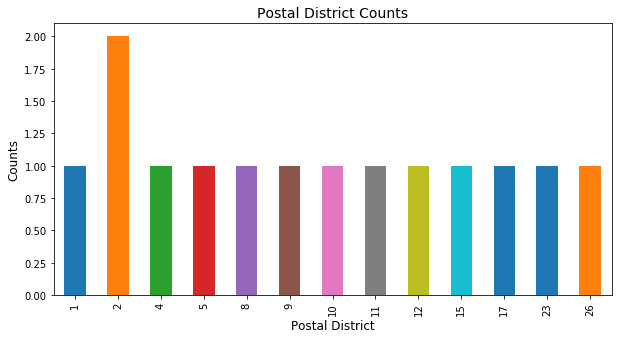

,Postal District,Neighborhood,Latitude,Longitude,2017 psf,2018 psf,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,1,People's Park,1.284139,103.842683,2333.80,2540.88,Hotel,Japanese Restaurant,Cocktail Bar,Café,Chinese Restaurant,Spanish Restaurant,Dessert Shop,Wine Bar,Seafood Restaurant,Korean Restaurant
4,2,Anson,1.273845,103.844512,2366.87,3362.38,Japanese Restaurant,Coffee Shop,Café,Ramen Restaurant,Hotel,Bakery,Food Court,Italian Restaurant,Spanish Restaurant,Cocktail Bar
5,2,Tanjong Pagar,1.276419,103.842930,2366.87,3362.38,Japanese Restaurant,Coffee Shop,Italian Restaurant,Ramen Restaurant,Bakery,Hotel,Café,Cocktail Bar,Food Court,Asian Restaurant
9,4,Telok Blangah,1.270586,103.809863,1951.18,0.00,Chinese Restaurant,Trail,Café,Playground,Metro Station,Seafood Restaurant,Scenic Lookout,Food Court,Asian Restaurant,Electronics Store
12,5,Hong Leong Garden,1.317277,103.759530,1313.50,1514.37,Chinese Restaurant,Food Court,Coffee Shop,Noodle House,Japanese Restaurant,Snack Place,Bus Station,Shopping Mall,Asian Restaurant,Gym
20,8,Jalan Besar,1.310040,103.860321,1588.92,1739.41,Indian Restaurant,Café,Chinese Restaurant,Restaurant,Coffee Shop,Bakery,Hostel,BBQ Joint,Hotel,Thai Restaurant
23,9,Cairnhill,1.306807,103.836841,2160.08,2898.32,Hotel,Boutique,Japanese Restaurant,Shopping Mall,Sushi Restaurant,Cosmetics Shop,Bakery,Ramen Restaurant,Chinese Restaurant,Coffee Shop
27,10,Holland Road,1.310637,103.795763,2336.07,2923.92,Bakery,Chinese Restaurant,Japanese Restaurant,Indian Restaurant,Dessert Shop,Ice Cream Shop,Coffee Shop,Food Court,Steakhouse,Asian Restaurant
29,11,Watten Estate,1.332306,103.811079,2246.44,2477.50,Japanese Restaurant,Italian Restaurant,Café,Asian Restaurant,Bakery,Noodle House,Coffee Shop,Malay Restaurant,Indian Restaurant,Supermarket
32,12,Balestier,1.321626,103.852170,1568.64,1798.11,Chinese Restaurant,Hotel,Asian Restaurant,Food Court,Café,Noodle House,Soup Place,Coffee Shop,Bakery,Dessert Shop


In [415]:
cluster_0 = sg_latlng_psf_venues.loc[sg_latlng_psf_venues['Cluster Labels'] == 0, sg_latlng_psf_venues.columns[[1] + list(range(2, sg_latlng_psf_venues.shape[1]))]]
print('Average 2018 Psf = {}'.format(round(cluster_0['2018 psf'].mean(),2)))

cluster_0['Postal District'].value_counts().sort_index().plot(kind='bar',
        figsize=(10, 5),
        width=0.5)
plt.xlabel('Postal District', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Postal District Counts", fontsize=14)
plt.show()

cluster_0

#### Cluster 1

In [422]:
# Create map cluster_1 
map_clusters_1 = folium.Map(location=[sg_lat, sg_lng], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(cluster_1['Latitude'], cluster_1['Longitude'], cluster_1['Neighborhood']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='grey',
        fill=True,
        fill_color='darkviolet',
        fill_opacity=0.8).add_to(map_clusters_1)
          
map_clusters_1

Average 2018 Psf = 1658.66


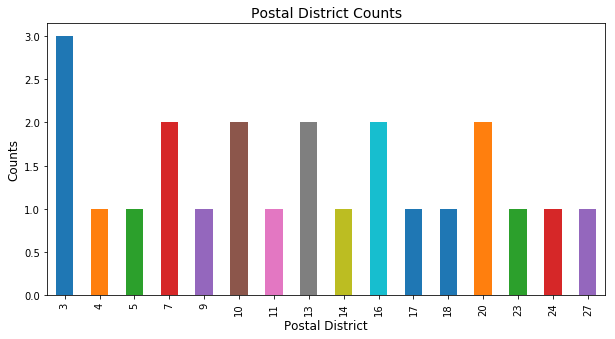

,Postal District,Neighborhood,Latitude,Longitude,2017 psf,2018 psf,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,3,Bukit Merah,1.285917,103.813315,1746.67,1799.23,Chinese Restaurant,Coffee Shop,Food Court,Café,Asian Restaurant,Fast Food Restaurant,Park,Sandwich Place,Noodle House,Supermarket
7,3,Queenstown,1.300000,103.800000,1746.67,1799.23,Chinese Restaurant,Café,Food Court,Coffee Shop,Indian Restaurant,Italian Restaurant,Bus Station,Dessert Shop,Noodle House,Stadium
8,3,Tiong Bahru,1.286197,103.825765,1746.67,1799.23,Chinese Restaurant,Café,Noodle House,Asian Restaurant,Coffee Shop,Food Court,Bakery,Bookstore,Italian Restaurant,Hotel
10,4,Harbourfront,1.264752,103.820157,1951.18,0.00,Chinese Restaurant,Toy / Game Store,Coffee Shop,Clothing Store,Fast Food Restaurant,Café,Candy Store,Spa,Multiplex,Bakery
13,5,Clementi New Town,1.304889,103.773139,1313.50,1514.37,Coffee Shop,College Cafeteria,Sandwich Place,Food Truck,Market,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Sushi Restaurant,Gym / Fitness Center
16,7,Middle Road,1.309982,103.856206,2156.00,2199.45,Indian Restaurant,Café,Chinese Restaurant,Hotel,Hostel,Restaurant,Bakery,BBQ Joint,Supermarket,Vegetarian / Vegan Restaurant
17,7,Golden Mile,1.302782,103.863987,2156.00,2199.45,Hotel,Thai Restaurant,Café,Restaurant,Bakery,Japanese Restaurant,Supermarket,Coffee Shop,Indonesian Restaurant,Chinese Restaurant
24,9,River Valley,1.292004,103.843694,2160.08,2898.32,Japanese Restaurant,Hotel,Café,Bar,Nightclub,Gym,Italian Restaurant,Seafood Restaurant,Yoga Studio,Ramen Restaurant
25,10,Ardmore,1.309499,103.828869,2336.07,2923.92,Hotel,Japanese Restaurant,Boutique,Sushi Restaurant,French Restaurant,Italian Restaurant,Bakery,Coffee Shop,Spanish Restaurant,Bubble Tea Shop
28,10,Tanglin,1.307131,103.818612,2336.07,2923.92,Café,Hotel,Japanese Restaurant,Bar,French Restaurant,Thai Restaurant,Spa,Korean Restaurant,Lounge,Indian Restaurant


In [411]:
cluster_1 = sg_latlng_psf_venues.loc[sg_latlng_psf_venues['Cluster Labels'] == 1, sg_latlng_psf_venues.columns[[1] + list(range(2, sg_latlng_psf_venues.shape[1]))]]
print('Average 2018 Psf = {}'.format(round(cluster_1['2018 psf'].mean(),2)))

cluster_1['Postal District'].value_counts().sort_index().plot(kind='bar',
        figsize=(10, 5),
        width=0.5)
plt.xlabel('Postal District', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Postal District Counts", fontsize=14)
plt.show()

cluster_1

#### Cluster 2

In [423]:
# Create map cluster_2 
map_clusters_2 = folium.Map(location=[sg_lat, sg_lng], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(cluster_2['Latitude'], cluster_2['Longitude'], cluster_2['Neighborhood']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='grey',
        fill=True,
        fill_color='aqua',
        fill_opacity=0.8).add_to(map_clusters_2)
          
map_clusters_2

In [371]:
cluster_2 = sg_latlng_psf_venues.loc[sg_latlng_psf_venues['Cluster Labels'] == 2, sg_latlng_psf_venues.columns[[1] + list(range(2, sg_latlng_psf_venues.shape[1]))]]
print('Average 2018 Psf = {}'.format(round(cluster_2['2018 psf'].mean(),2)))

cluster_2

Average 2018 Psf = 1371.44


,Postal District,Neighborhood,Latitude,Longitude,2017 psf,2018 psf,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,22,Jurong,1.339613,103.705986,1305.4,1371.44,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Café,Chinese Restaurant,Dessert Shop,Food Court,Playground,Karaoke Bar,Coffee Shop


#### Cluster 3

In [424]:
# Create map cluster_3
map_clusters_3 = folium.Map(location=[sg_lat, sg_lng], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(cluster_3['Latitude'], cluster_3['Longitude'], cluster_3['Neighborhood']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='grey',
        fill=True,
        fill_color='gold',
        fill_opacity=0.8).add_to(map_clusters_3)
          
map_clusters_3

Average 2018 Psf = 1500.78


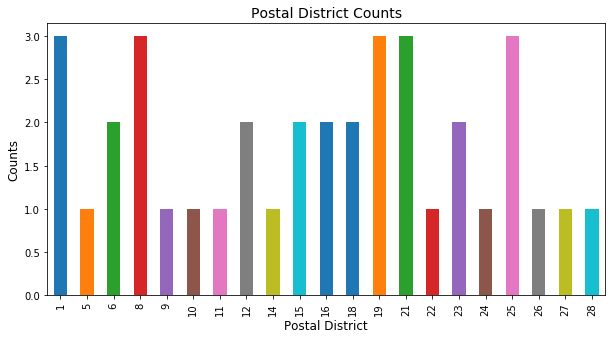

,Postal District,Neighborhood,Latitude,Longitude,2017 psf,2018 psf,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Raffles Place,1.283595,103.851568,2333.80,2540.88,Hotel,Cocktail Bar,Korean Restaurant,Yoga Studio,Japanese Restaurant,Italian Restaurant,Café,Coffee Shop,Gym,Chinese Restaurant
1,1,Cecil,1.280805,103.848668,2333.80,2540.88,Hotel,Korean Restaurant,Gym / Fitness Center,Chinese Restaurant,Cocktail Bar,Restaurant,Café,Bar,Japanese Restaurant,Coffee Shop
2,1,Marina,1.263270,103.820293,2333.80,2540.88,Theme Park Ride / Attraction,Clothing Store,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Spa,Multiplex,Theme Park,Bakery,Toy / Game Store
11,5,Pasir Panjang,1.282722,103.778282,1313.50,1514.37,Bar,Asian Restaurant,Indian Restaurant,Convenience Store,Food Court,Metro Station,Chinese Restaurant,Theme Park,Grocery Store,Sculpture Garden
14,6,High Street,1.290454,103.849359,0.00,0.00,Hotel,Japanese Restaurant,Café,Cocktail Bar,French Restaurant,Yoga Studio,Gym / Fitness Center,Italian Restaurant,Park,Nightclub
15,6,Beach Road (part),1.309404,103.857890,0.00,0.00,Indian Restaurant,Café,Chinese Restaurant,Hostel,BBQ Joint,Restaurant,Bakery,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop
18,8,Little India,1.306300,103.849600,1588.92,1739.41,Indian Restaurant,Café,Chinese Restaurant,Hotel,Vegetarian / Vegan Restaurant,Clothing Store,Dessert Shop,Sporting Goods Shop,Bakery,Sports Bar
19,8,Farrer Park,1.312755,103.854374,1588.92,1739.41,Indian Restaurant,Café,Chinese Restaurant,Hotel,Hostel,Vegetarian / Vegan Restaurant,Soup Place,Noodle House,BBQ Joint,Dessert Shop
21,8,Lavender,1.308047,103.863345,1588.92,1739.41,Coffee Shop,Restaurant,Chinese Restaurant,Café,Hostel,Hotel,BBQ Joint,Thai Restaurant,Indian Restaurant,Bakery
22,9,Orchard,1.300701,103.839551,2160.08,2898.32,Japanese Restaurant,Hotel,Shopping Mall,Bubble Tea Shop,Clothing Store,Cosmetics Shop,Sushi Restaurant,Boutique,Wine Bar,Coffee Shop


In [419]:
cluster_3 = sg_latlng_psf_venues.loc[sg_latlng_psf_venues['Cluster Labels'] == 3, sg_latlng_psf_venues.columns[[1] + list(range(2, sg_latlng_psf_venues.shape[1]))]]
print('Average 2018 Psf = {}'.format(round(cluster_3['2018 psf'].mean(),2)))

cluster_3['Postal District'].value_counts().sort_index().plot(kind='bar',
        figsize=(10, 5),
        width=0.5)
plt.xlabel('Postal District', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Postal District Counts", fontsize=14)
plt.show()

cluster_3

### 3C.  Discussion<a name="Discussion"></a>

There are 4 clusters from the analysis mainly:

1) cluster_0: 13 neighborhood districts located maninly central with only 1 neighborhood distict in the eastern part of Singapore. The average 2018 psf was at 1945.12 which was the highest amoung the 4 clusters. The common venues within 1 km of the districts in cluster_0 are generally Japanese Restaurant, Chinese Restaurant, Café and Coffee Shop.

2) cluster_1: 16 neigborhood districts located mainly from north to south, east and a couple in north west of Singapore. The average 2018 psf was at 1658.66 which was the second highest of the 4 clusters. The common venues within 1 km of the districts in cluster_1 are generally Chinese Restaurant, Food Court, Café, Convenience Store.

3) cluster_2: 1 neightborhood district located in the west of Singapore. The 2018 psf was at 1371.44 which was the lowest of the 4 clusters. The common venues within 1 km of the district in cluster_2 are generally Resturants, Food Court, Playground and Karaoke Bar.

4) cluster_3: 21 neighborhood districts spread over Singapore with average 2018 psf of 1500.78. The common venues within 1 km of the districts in cluster_3 are generally Chinese Restaurant, Japanese Restaurant, Coffee Shop, Café, Bus Station and Supermarket.

Looking at the 4 clusters, it appears that restauarants and cafe are easily accessible within 1 km in almost all neighborhood districts in Singapore. There are no distinct separation of the clusters in terms of locations. However, in terms of average psf, there are 4 different levels. The unique cluster which consist only 1 neighborhood district will be cluster_2 and hold the lowest psf value.

### 4.  Conclusion<a name="Conclusion"></a>

To conclude the analysis, we revisit the business problem "Does souring prices of private property affected by factors such as resturants, cafes, bars, shopping malls or places of visit in Singapore?". The data from Fourquare provides information of nearby resturants, cafes, bars, shopping malls or places of visit in Singapore within the neigborhoods. The analysis does not show distinct relationship between venues nearby collected from Foursquare and private property prices. However, further analysis can be acheive by using other type of data such as geo locations of train stations, future development of districts and etc.